# Module 12 Lab - Distance Based Machine Learning

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

We're getting to the point in the semester where you should be know the drill.

This module covered 3 basic problems: supervised learning (classification, regression), unsupervised learning (clustering) and recommenders (collaborative filtering based systems related to missing value imputation) using distance/similarity. We're only going to cover the first 2 in this lab.

You should definitely use [Scikit Learn](http://scikit-learn.org/stable/) and refer to the documentation for this assignment.

Remember to create a new random seed for each experiment (if needed) and save it.

**Problem 1. kNN Regression**

Use k-Nearest Neighbors *regression* for the insurance data set. Make sure you do the following:

1. Pick an appropriate evaluation metric.
2. Validation curves to find the best value of k.
3. Learning curves to see if we are high bias or high variance and suggest ways to improve the model.
4. 10 fold cross validation to estimate the mean metric and its credible interval.
5. Was this better than the best linear regression model you estimated in Lab 11? Use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means.

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import random
import patsy
import matplotlib.pyplot as plt
import scipy.stats as stats
import models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

#### Using some code from https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a to build an initial model 

In [3]:
insurance = pd.read_csv('insurance.csv')

In [14]:
insurance2 = pd.get_dummies(insurance,columns=["sex",'region','smoker'])

In [15]:
X = insurance2.drop(columns=['charges'])

In [16]:
y = insurance2['charges']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=123)

In [20]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [23]:
knn.predict(X_test)[0:5]

array([22499.6102    , 22569.22392667, 13752.18705   ,  5952.85036667,
       17663.45730667])

In [24]:
knn.score(X_test,y_test)

0.15104892360751643

The scoring part of K nearest neighbors uses R^2, and it can be seen here that the R^2 is only .15, indicating a low level of fit. 

### testing different values of k on R^2

In [30]:
knn_r2 = pd.DataFrame()
for i in range(1,50):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    r2 = knn.score(X_test,y_test)
    knn_r2 = knn_r2.append({'k':i,'r2':r2},ignore_index = True)

In [31]:
knn_r2

,k,r2
0,1.0,-0.190926
1,2.0,0.092260
2,3.0,0.151049
3,4.0,0.208795
4,5.0,0.173720
5,6.0,0.194970
6,7.0,0.201293
7,8.0,0.216304
8,9.0,0.191523
9,10.0,0.206113


It appears that the greatest R^2 is when k=8, so that is what we will use. 

### Learning Curves

In [53]:
knn = KNeighborsRegressor(n_neighbors=8)
np.random.seed(1234)
val_curve = pd.DataFrame()
for i in np.linspace(.01,1,100):
    insurance_temp = insurance2.sample(frac=i)
    X = insurance_temp.drop(columns=['charges'])
    y = insurance_temp['charges']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=123)
    knn.fit(X_train,y_train)
#     t=knn.score(X_train,y_train)
    t=np.std(knn.predict(X_train)-y_train)
#     v=knn.score(X_test,y_test)
    v=np.std(knn.predict(X_test)-y_test)
    val_curve = val_curve.append({'training_r2':t,'validation_r2':v},ignore_index=True)

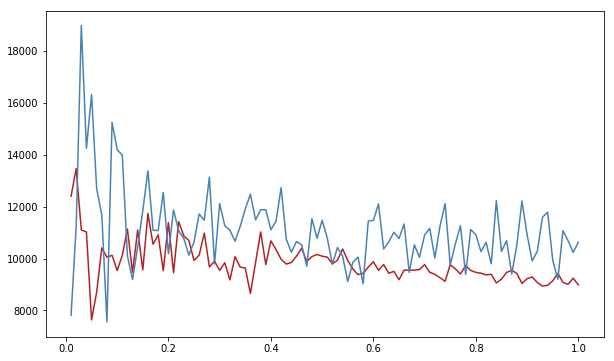

In [54]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot( np.linspace(.01,1,100), val_curve['training_r2'], color="firebrick")
ax.plot( np.linspace(.01,1,100), val_curve['validation_r2'], color="steelblue")
plt.show()
plt.close()

From this plot it looks to be somewhat high bias, but it looks like it's somewhat converging. A little more data might help. It could also be useful to do some variable selection like we had done in the last module. 

### Cross Validation

In [57]:
r2 = []
sigma = []
knn = KNeighborsRegressor(n_neighbors=8)
np.random.seed(11224)
kf = KFold(n_splits = 10)
for i in range(3):
    insurance_random = insurance2.sample(frac=1)
    X = insurance_random.drop(columns=['charges'])
    y = insurance_random[['charges']]
    for train_index,test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index,:], X.iloc[test_index,:], y.iloc[train_index,:], y.iloc[test_index,:]
        knn.fit(X_train,y_train)
        r2.append(knn.score(X_test,y_test))
        sigma.append(np.sqrt(mean_squared_error(y_test,knn.predict(X_test))))

In [59]:
np.mean(r2)

0.25290293013452664

In [60]:
stats.mstats.mquantiles( r2, [0.05, 0.95])

array([0.14860222, 0.36203645])

It looks like the 90% CI for R^2 is between .1486 and .3620

### Comparing to Lab 11
I'm not really sure what difference of means we are looking at, to be honest.

In [106]:
stats.mstats.mquantiles( sigma, [0.05, 0.95])

array([ 9202.97318405, 11733.69976959])

Based on my lab 11, I got r^2 as

array([0.76170671, 0.92008367])

and sigma as

array([3447.68026489, 5357.46633358])

So I'm not sure if the K-means clustering I'm using here is horribly suboptimal because we did no variable selection or transformation, or if it's just a worse regression, but it seems like this regression did significantly worse than the one I had in lab 11. 

** Problem 2. Clustering **

Use k-Means Clustering on clustering problems of your own creation in two dimensions ($x_1$ and $x_2$). You should explore the following points: 

1. What if the data has no clusters (there are no hidden categorical variables)?
2. Now assume that you have some "hidden" categorical variable and the clusters are compact and distinct as well as having the same variance? What does the Elbow Method show for the k you should use?
3. Now assume that you have some "hidden" categorical variable and the clusters are disperse? Different variances? What does the Elbow Method show for the k you should use?

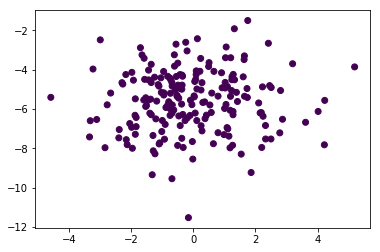

In [87]:
## Code from https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097
data = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')

In [89]:
# create kmeans object
kmeans = KMeans(n_clusters=4)
# fit kmeans object to data
kmeans.fit(points)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(points)

[[-1.02877832 -4.83920853]
 [ 1.27285821 -4.11889876]
 [-1.231457   -7.27876129]
 [ 1.69634154 -6.82868689]]


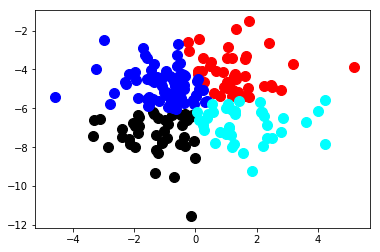

In [90]:
plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='cyan')

We can see that when we don't have distinct groups, the k-means clustering will force groups to happen. In this case, it's approximately the 4 quandrants of the plane. 

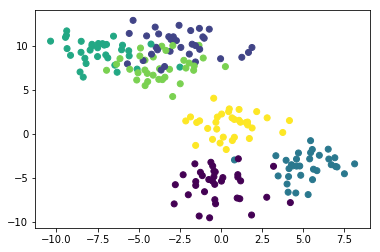

In [92]:
## Code from https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097
data = make_blobs(n_samples=200, n_features=4, centers=6, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')

In [93]:
# create kmeans object
kmeans = KMeans(n_clusters=6)
# fit kmeans object to data
kmeans.fit(points)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(points)

[[ 5.11141316 -3.81658026 -3.14234837 -3.55769434]
 [-3.65534358  7.56939405  3.51311782 -2.63207655]
 [-2.49108413 10.13741764 -2.06521949  5.20998468]
 [ 0.55339744  1.04466112  8.32282037  1.70010901]
 [-7.36647753  9.33816519  8.201567    0.8633204 ]
 [-0.42497075 -5.82062048 -4.69062389 -2.14390283]]


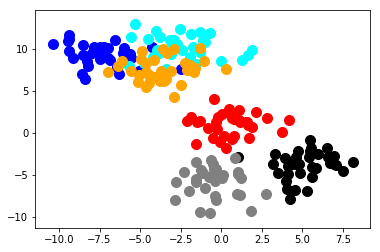

In [96]:
plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='cyan')
plt.scatter(points[y_km ==4,0], points[y_km == 4,1], s=100, c='orange')
plt.scatter(points[y_km ==5,0], points[y_km == 5,1], s=100, c='gray')

In [100]:
##help from https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
sse = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    # fit kmeans object to data
    kmeans.fit(points)
    sse.append(kmeans.inertia_)
    

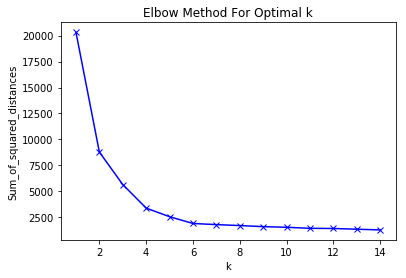

In [102]:
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the best cluster is around where we had said, which is around 6 and the true number of clusters in the data

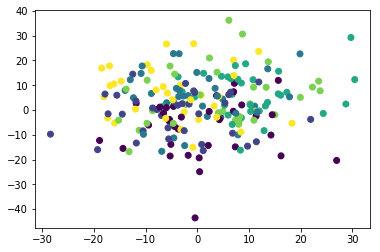

In [103]:
## Code from https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097
data = make_blobs(n_samples=200, n_features=10, centers=6, cluster_std=10, random_state=50)
# create np array for data points
points = data[0]
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')

In [104]:
##help from https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
sse = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    # fit kmeans object to data
    kmeans.fit(points)
    sse.append(kmeans.inertia_)
    

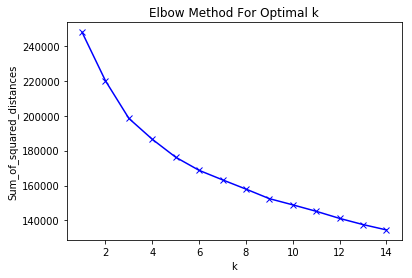

In [105]:
plt.plot(range(1,15), sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

When the data has many hidden "features" and has high variance, the elbow method seemingly fails to work. It way overshoots the actual number of centers and does not really have a meaningful inflection point.